Here, you develop the E+M Runge-Kuttas. (You want to be able to graph two functions at a time. The plotting functions can handle it, but the other functions aren't built for it specifically because your cases are simple enough that the answer for the B field is proportional to the E Field.)

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
def Const(omega, x, sigma, mu, deriv, cellAve):
    degFreed = omega.degFreed
    k = 1
    ct = 0
    
    fact = 2.0 * np.pi * k
    u = (1.0 / fact) * (cos(fact * (x[:-1] - ct)) - cos(fact * (x[1:] - ct)))
    return u

In [3]:
nh_min = 16
refRatio = 2
CFL = np.sqrt(0.5)
nt = 1
x_0 = 0.
x_1 = 0.5
Hans = False

deriv = 'U'
RK = 1
order = 1

L = 1
locs = [x_1]
epsilons = [0.5, 0.5] # [1, 1]
mus = [0.5, 0.5] # [1, 1]

func = WFT.Gauss

In [4]:
if (RK == 1):
    TimeIntegratorFunc = ST.ForwardEuler
else:
    if (RK == 2):
        TimeIntegratorFunc = ST.MidpointMeth
    else:
        TimeIntegratorFunc = ST.RK4

if (deriv == 'U'):
    # DiffMatFunc = OT.Upwind1D
    DiffFunc = TT.Upwind#ST.Upwind
else:
    # DiffMatFunc = OT.CenterDiff1D
    DiffFunc = TT.CenterDiff#ST.CenterDiff

In [5]:
def Block(matrica, var = 1):
    matricaList = [matrica for k in range(var)]
    matrice = block_diag(*matricaList)
    return matrice

In [6]:
omegaAMR = BT.Grid(nh_min)
finehalf = list(np.arange(int(nh_min / refRatio)))# + int(nh / refRatio))
omegaAMR.AddPatch(refRatio, finehalf)
degFreed = omegaAMR.degFreed
nh_max = omegaAMR.nh_max

omegaF = BT.Grid(nh_max)
omegaC = BT.Grid(nh_min)

In [7]:

physicsAMR = BT.PhysProps(omegaAMR, epsilons, mus, locs, L)
c = physicsAMR.cVec
cMatAMR = physicsAMR.cMat

physicsC = BT.PhysProps(omegaC, epsilons, mus, locs, L)
cC = physicsC.cVec
cMatC = physicsC.cMat

physicsF = BT.PhysProps(omegaF, epsilons, mus, locs, L)
cF = physicsF.cVec
cMatF = physicsF.cMat

distance is
 [ 0.5      0.46875  0.4375   0.40625  0.375    0.34375  0.3125   0.28125  0.25     0.21875  0.1875   0.15625  0.125    0.09375  0.0625   0.03125  0.      -0.0625  -0.125   -0.1875  -0.25    -0.3125  -0.375   -0.4375  -0.5    ] 

distance is
 [1.      0.96875 0.9375  0.90625 0.875   0.84375 0.8125  0.78125 0.75    0.71875 0.6875  0.65625 0.625   0.59375 0.5625  0.53125 0.5     0.4375  0.375   0.3125  0.25    0.1875  0.125   0.0625  0.     ] 

distance is
 [ 0.5     0.4375  0.375   0.3125  0.25    0.1875  0.125   0.0625  0.     -0.0625 -0.125  -0.1875 -0.25   -0.3125 -0.375  -0.4375 -0.5   ] 

distance is
 [1.     0.9375 0.875  0.8125 0.75   0.6875 0.625  0.5625 0.5    0.4375 0.375  0.3125 0.25   0.1875 0.125  0.0625 0.    ] 

distance is
 [ 0.5      0.46875  0.4375   0.40625  0.375    0.34375  0.3125   0.28125  0.25     0.21875  0.1875   0.15625  0.125    0.09375  0.0625   0.03125  0.      -0.03125 -0.0625  -0.09375 -0.125   -0.15625 -0.1875  -0.21875 -0.25    -0.28125 -0.3

In [8]:
def ExpandMat(mat):
    errorLoc = 'ERROR:\nOperatorTools:\nExpandMat:\n' # Don't know where we're putting this yet.
    errorMess = ''
    shape = np.shape(mat)
    if (len(shape) != 2):
        errorMess = 'mat must be a rank-2 matrix!'
    
    else:
        if (shape[0] != shape[1]):
            errorMess = 'mat must be a square matrix!'
    if (errorMess != ''):
        sys.exit(errorLoc + errorMess)
    
    size_min = shape[0]
    size_max = 2 * size_min
    newMat = np.zeros((size_max, size_max), int)
    newMat[0:size_max:2, 0:size_max:2] = mat
    newMat[1:size_max + 1:2, 1:size_max + 1:2] = mat
    return newMat

If  
$v_{j}^{s} = \frac{E_{j}^{s} - c B_{j}^{s}} {2 c}$  
and  
$v_{n + j}^{s} = \frac{E_{j}^{s} + c B_{j}^{s}}{2 c}$  
and  
$B_{j}^{0} = \frac{E_{j}^{0}}{c}$,  
then  
$c \Delta t \frac{\partial v_{j}^{0}}{\partial x} = 0$  
and  
$c \Delta t \frac{\partial v_{n + j}^{0}}{\partial x} = \frac{\sigma_{CFL}}{c} (E_{j}^{0} - E_{j - 1}^{0})$.  
  
If  
$v_{j}^{1} = v_{j}^{0} + c \Delta t \frac{\partial v_{j}^{0}}{\partial x}$  
and  
$v_{n + j}^{1} = v_{n + j}^{0} - c \Delta t \frac{\partial v_{n + j}^{0}}{\partial x}$,  
then  
$v_{j}^{1} = 0$  
and  
$v_{n + j}^{1} = \frac{1}{c} [(1 - \sigma_{CFL}) E_{j}^{0} + \sigma_{CFL} E_{j - 1}^{0}]$. 
  
If  
$E_{j}^{s} = c (v_{j}^{s} + v_{n + j}^{s})$  
and  
$B_{j}^{s} = v_{n + j}^{s} - v_{j}^{s}$,  
then  
$E_{j}^{1} = E_{j}^{0} - \sigma_{CFL} (E_{j}^{0} - E_{j - 1}^{0})$  
and  
$B_{j}^{1} = \frac{1}{c} [E_{j}^{0} - \sigma_{CFL} (E_{j}^{0} - E_{j - 1}^{0})] = B_{j}^{0} - \sigma_{CFL} (B_{j}^{0} - B_{j - 1}^{0})$.  


In [9]:
def Check(omega, physics, CFL, u0stack, v_i, v_f, u_f, op):
    
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    c = physics.cVec[0]
    cMat = physics.cMat
    roundFact = 15
    
    I = np.eye(degFreed)
    dx, dt = ST.FindDxDt(omega, CFL, cMat)
    print('')
    print('')
    print('After 1 Forward Euler timestep on a uniform grid:')
    print('')
    print('The derivative of v should be')
    uShiftM = np.roll(u0stack, 1)
    uShiftP = np.roll(u0stack, -1)
    alpha_min = (1. - c) / (2 * c)
    alpha_plu = (1. + c) / (2 * c)
    derivShould1 = np.zeros(degFreed, float)
    derivShould2 = CFL * (uShiftM - u0stack) # The factor of c is already embedded within u0stack!!!
    derivShould = np.round(np.asarray(np.append(derivShould1[:degFreed], derivShould2[degFreed:])), roundFact)
    print(derivShould)
    print('In actuality, it is')
    derivres = np.round(dt * op @ v_i, roundFact)
    print(derivres)
    print('This is off by a factor of')
    r1 = np.round([derivShould[i] / derivres[i] for i in range(len(derivres))], 12)
    r1[derivShould == derivres] = 1
    print(r1)
    indices1 = np.where(r1 != 1)
    print('Indices:', indices1[0])
    print('Factors:', r1[indices1[0]])
    print('')
    print('v itself should be')
    shouldbe1 = np.zeros(degFreed, float) # alpha_min * (((1. - CFL) * u0stack) + (CFL * uShiftP))
    shouldbe2 = ((1. - CFL) * u0stack) + (CFL * uShiftM) # The factor of c is already embedded within u0stack!!!
    shouldbe = np.round(np.asarray(np.append(shouldbe1[:degFreed], shouldbe2[degFreed:])), roundFact)
    print(shouldbe)
    print('In actuality, it is')
    v_f1 = np.round(v_f, roundFact)
    print(v_f1)
    print('This is off by a factor of')
    r = np.round([shouldbe[i] / v_f1[i] for i in range(len(v_f))], roundFact)
    r[shouldbe == v_f1] = 1
    print(r)
    indices = np.where(r != 1)
    print('Indices:', indices[0])
    print('Factors:', r[indices[0]])
    print('')
    print('u should be')
    u1 = ((1. - CFL) * u0stack) + (CFL * uShiftM) # The factor of c is already embedded within u0stack!!!

    u = np.round(u1, roundFact)
    print(u)
    print('In actuality, it is')
    u_f1 = np.round(u_f, roundFact)
    print(u_f1)
    print('This is off by a factor of')
    r2 = np.round([u[i] / u_f1[i] for i in range(len(u_f))], roundFact)
    r2[u == u_f1] = 1
    print(r2)
    indices2 = np.where(r2 != 1)
    print('Indices:', indices2[0])
    print('Factors:', r2[indices2[0]])
    return

In [10]:
# THIS IS FOR IF YOU DON'T DIVIDE B BY C!!!!!!!!!!

# def Check(omega, physics, CFL, u0stack, v_i, v_f, u_f, op):
    
#     degFreed = omega.degFreed
#     nh_min = omega.nh_min
#     c = physics.cVec[0]
#     cMat = physics.cMat
#     roundFact = 15
    
#     I = np.eye(degFreed)
#     dx, dt = ST.FindDxDt(omega, CFL, cMat)
#     print('')
#     print('')
#     print('After 1 Forward Euler timestep on a uniform grid:')
#     print('')
#     print('The derivative of v should be')
#     uShiftM = np.roll(u0stack, 1)
#     uShiftP = np.roll(u0stack, -1)
#     alpha_min = (1. - c) / (2 * c)
#     alpha_plu = (1. + c) / (2 * c)
#     derivShould1 = alpha_min * CFL * (uShiftP - u0stack)
#     derivShould2 = -alpha_plu * CFL * (u0stack - uShiftM)
#     derivShould = np.round(np.asarray(np.append(derivShould1[:degFreed], derivShould2[degFreed:])), roundFact)
#     print(derivShould)
#     print('In actuality, it is')
#     derivres = np.round(dt * op @ v_i, roundFact)
#     print(derivres)
#     print('This is off by a factor of')
#     r1 = np.round([derivShould[i] / derivres[i] for i in range(len(derivres))], 12)
#     r1[derivShould == derivres] = 1
#     print(r1)
#     indices1 = np.where(r1 != 1)
#     print('Indices:', indices1[0])
#     print('Factors:', r1[indices1[0]])
#     print('')
#     print('v itself should be')
#     shouldbe1 = alpha_min * (((1. - CFL) * u0stack) + (CFL * uShiftP))
#     shouldbe2 = alpha_plu * (((1. - CFL) * u0stack) + (CFL * uShiftM))
#     shouldbe = np.round(np.asarray(np.append(shouldbe1[:degFreed], shouldbe2[degFreed:])), roundFact)
#     print(shouldbe)
#     print('In actuality, it is')
#     v_f1 = np.round(v_f, roundFact)
#     print(v_f1)
#     print('This is off by a factor of')
#     r = np.round([shouldbe[i] / v_f1[i] for i in range(len(v_f))], roundFact)
#     r[shouldbe == v_f1] = 1
#     print(r)
#     indices = np.where(r != 1)
#     print('Indices:', indices[0])
#     print('Factors:', r[indices[0]])
#     print('')
#     print('u should be')
#     u1 = ((1. - CFL) * u0stack) + ((CFL / 2) * (((1 + c) * uShiftM) + ((1 - c) * uShiftP)))
#     u2 = ((1. - CFL) * u0stack) + ((CFL / (2 * c)) * (((1 + c) * uShiftM) - ((1 - c) * uShiftP)))
# #     for i in range(nt):
# #         u1 = ST.RungeKutta(omega, physics, I, u0stack[:degFreed], 1, CFL, RK, op = -op[:degFreed, :degFreed])
# #         u2 = ST.RungeKutta(omega, physics, I, u0stack[degFreed:], 1, CFL, RK, op = -op[:degFreed, :degFreed])
#     u = np.round(np.asarray(np.append(u1[:degFreed], u2[degFreed:])), roundFact)
#     print(u)
#     print('In actuality, it is')
#     u_f1 = np.round(u_f, roundFact)
#     print(u_f1)
#     print('This is off by a factor of')
#     r2 = np.round([u[i] / u_f1[i] for i in range(len(u_f))], roundFact)
#     r2[u == u_f1] = 1
#     print(r2)
#     indices2 = np.where(r2 != 1)
#     print('Indices:', indices2[0])
#     print('Factors:', r2[indices2[0]])
#     return

In [11]:
# Creates anti-block-diagonal matrix 
def ConvertOp(omega, physics):
    degFreed = omega.degFreed
    cMat = physics.cMat
    cVec = physics.cVec
    c = cVec[0]
    cVecs = np.asarray(np.append(cVec, -cVec))
    
    # eigVals = #[item for sublist in zip(cVec, -cVec) for item in sublist]
    I = np.eye(degFreed)
    normConst = 1. #  / np.sqrt(c**2 + 1)
    op = normConst * np.asarray(np.block([[cMat, cMat], [-I, I]]))
    diagMat = np.diag(cVecs)
    return op, diagMat

In [12]:
def WaveEqRK(omega, physics, waves, u0, nt, CFL, RK, derivOp, left = True):
    # Unpack requisite attributes.
    degFreed = omega.degFreed
    cMat = physics.cMat
    c = cMat[0, 0]
    l = omega.levels
    
    # Stack the initial condition.
    u0stack = np.asarray(np.append(u0, u0 / c)) # I'm not sure how to relate the initial condition for the E and B fields.
    
    # Create change of basis matrix.
    convertOp, diagMat = ConvertOp(omega, physics)
    convertOpinv = LA.inv(convertOp)
    
    # Change basis of initial condtion.
    v = np.asarray(convertOpinv @ u0stack)
    v_i = v.copy()
    
    # Turn difference matrix into block diagonal.
    # THIS IS SCOTCH TAPE.
    derivMat = OT.Block([-derivOp.transpose(), derivOp]) # ExpandMat(derivOp)
    
    # Create identity matrix to appease the current structure of my RK function.
    I = np.eye(2 * degFreed)
    
    # Turn Fourier matrix into block diagonal.
    wavesMat = OT.Block(waves, var = 2)
    
    # Create operator to pass into RK function.
    op = diagMat @ derivMat

    for i in range(nt):
        v = ST.RungeKutta(omega, physics, I, v, 1, CFL, RK, op = op)
    
    # Convert v back to space-space.
    u = convertOp @ v

    # Convert u to k space.
    fCoefs = LA.inv(wavesMat) @ u
    
    # Run check.
    if ((nt == 1) and (RK == 1) and (l == 0)):
        Check(omega, physics, CFL, u0stack, v_i, v, u, op)
    
    return fCoefs, v

In [13]:
op, diagMat = ConvertOp(omegaC, physicsC)

# print(op)
print(LA.inv(op))

[[ 0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  

In [14]:
# c = ConvertParams(permitivity, permeability, L)
t, nt = ST.CalcTime(omegaAMR, CFL, cMatAMR, nt = nt)
print(t)
mu, sigma = WFT.GaussParams(x_0, x_1)
args = [mu, sigma]
wavesAMR = WT.MakeWaves(omegaAMR)
nullspace = OT.FindNullspace(omegaAMR, wavesAMR, Hans = Hans)
restrictOp = GTT.CoarsenOp(omegaAMR)
print('sig:', sigma, 'mu:', mu)

wavesF = WT.MakeWaves(omegaF)
wavesC = WT.MakeWaves(omegaC)

derivMat = TT.ExactSpatOp(omegaAMR)
print(np.shape(cMatF))
print(np.shape(derivMat))
spatOp = -cMatF @ derivMat
timePropOp = LA2.expm(t * spatOp)

derivMatC = TT.ExactSpatOp(omegaC)
spatOpC = -cMatC @ derivMatC
timePropOpC = LA2.expm(t * spatOpC)


0.011048543456039806
sig: 0.25 mu: 0.03113530673812129
You are using ExactSpatOp in TestTools module!
(32, 32)
(32, 32)
You are using ExactSpatOp in TestTools module!


In [15]:
# wavesAMR = OT.Block(wavesAMR, var = 2)
# nullspace = OT.Block(nullspace, var = 2)
# restrictOp = OT.Block(restrictOp, var = 2)
# wavesC = OT.Block(wavesC, var = 2)
# wavesF = OT.Block(wavesF, var = 2)

opC = OT.SpaceDeriv(omegaC, order, deriv)#-cMatC @ OT.SpaceDeriv(omegaC, order, diff)
opF = OT.SpaceDeriv(omegaF, order, deriv)#-cMatF @ OT.SpaceDeriv(omegaF, order, diff)
opAMR = OT.SpaceDeriv(omegaAMR, order, deriv)#-cMatAMR @ OT.SpaceDeriv(omegaAMR, order, diff)

In [16]:
# For Gaussian:
waveInitC = WFT.InitCond(omegaC, physicsC, func, args)
# waveInitC = np.append(waveInitC, waveInitC)
waveInitF = WFT.InitCond(omegaF, physicsF, func, args)
# waveInitF = np.append(waveInitF, waveInitF)

FCoefsC = FFTT.FourierCoefs(wavesC, waveInitC)
FCoefsF = FFTT.FourierCoefs(wavesF, waveInitF)
FCoefsC1 = np.asarray(np.append(FCoefsC, FCoefsC))
FCoefsF1 = np.asarray(np.append(FCoefsF, FCoefsF))

# Find initial waveform on coarse, fine, and AMR grids.
waveInitC = wavesC @ FCoefsC
waveInitF = wavesF @ FCoefsF
waveInitAMR = restrictOp @ waveInitF

# Find Fourier coefficients for initial condition on AMR grid.
FCoefsAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, waveInitAMR)
FCoefsAMR1 = np.asarray(np.append(FCoefsAMR, FCoefsAMR))

wavePropC = WFT.WaveEq(omegaC, physicsC, func, args, t)#FFTT.FourierCoefs(wavesC, wavePropC) # timePropOpC @ FCoefsC
wavePropF = WFT.WaveEq(omegaF, physicsF, func, args, t)
wavePropAMR = WFT.WaveEq(omegaAMR, physicsAMR, func, args, t)#FFTT.FourierCoefs(wavesC, wavePropC) # timePropOpC @ FCoefsC

# Find propagated coeficients on coarse and fine grid.
FCoefsPropC = FFTT.FourierCoefs(wavesC, wavePropC)
FCoefsPropF = FFTT.FourierCoefs(wavesF, wavePropF)
FCoefsPropAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, wavePropAMR)
FCoefsPropC1 = np.asarray(np.append(FCoefsPropC, FCoefsPropC))
FCoefsPropF1 = np.asarray(np.append(FCoefsPropF, FCoefsPropF))
FCoefsPropAMR1 = np.asarray(np.append(FCoefsPropAMR, FCoefsPropAMR))

# TEST FOR EXACT GAUSSIAN AT NEW LOCATION.

# solverCoefsC = ST.RungeKutta(omegaC, physicsC, wavesC, waveInitC, nt, CFL, RK, op = opC) # TimeIntegratorFunc(omegaC, wavesC, waveInitC, nt, cMatC, CFL, DiffFunc)
# solverCoefsF = ST.RungeKutta(omegaF, physicsF, wavesF, waveInitF, nt, CFL, RK, op = opF) # TimeIntegratorFunc(omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
# solverCoefsAMR = ST.RungeKutta(omegaAMR, physicsAMR, wavesAMR @ nullspace, waveInitAMR, nt, CFL, RK, op = opAMR) # TimeIntegratorFunc(omegaAMR, wavesAMR @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order)

# solverCoefsC = WaveEqRK(omegaC, physicsC, wavesC, waveInitC, nt, CFL, RK, derivOp = opC) # TimeIntegratorFunc(omegaC, wavesC, waveInitC, nt, cMatC, CFL, DiffFunc)
# solverCoefsF = WaveEqRK(omegaF, physicsF, wavesF, waveInitF, nt, CFL, RK, derivOp = opF) # TimeIntegratorFunc(omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
# solverCoefsAMR = WaveEqRK(omegaAMR, physicsAMR, wavesAMR @ nullspace, waveInitAMR, nt, CFL, RK, derivOp = opAMR) # TimeIntegratorFunc(omegaAMR, wavesAMR @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order)

solverCoefsC, vC = WaveEqRK(omegaC, physicsC, wavesC, waveInitC, nt, CFL, RK, derivOp = opC) # TimeIntegratorFunc(omegaC, wavesC, waveInitC, nt, cMatC, CFL, DiffFunc)
solverCoefsF, vF = WaveEqRK(omegaF, physicsF, wavesF, waveInitF, nt, CFL, RK, derivOp = opF) # TimeIntegratorFunc(omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
solverCoefsAMR, vAMR = WaveEqRK(omegaAMR, physicsAMR, wavesAMR @ nullspace, waveInitAMR, nt, CFL, RK, derivOp = opAMR) # TimeIntegratorFunc(omegaAMR, wavesAMR @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order)




allCoefsC = PT.Load(FCoefsC1, FCoefsPropC1, solverCoefsC)#, FCoefsPropCTh)
allCoefsF = PT.Load(FCoefsF1, FCoefsPropF1, solverCoefsF)#, FCoefsPropFTh)
# allCoefsAMR = nullspace @ PT.Load(FCoefsAMR1, FCoefsPropAMR1, solverCoefsAMR)#, FCoefsPropAMRTh)




labels = ['Initial Wave', 'Exact Propagated Wave', 'RK Propagated Wave']#, 'Rotation Matrix Propagated Wave']




After 1 Forward Euler timestep on a uniform grid:

The derivative of v should be
[ 0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.         -0.         -0.00001314 -0.00984329 -0.20101758  0.          0.20101758  0.00984329  0.00001314  0.          0.         -0.         -0.         -0.          0.          0.          0.        ]
In actuality, it is
[ 0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.         -0.         -0.00001314 -0.00984329 -0.20101758  0.          0.20101758  0.00984329  0.00001314  0.          0.         -0.         -0.         -0.          0.          0.          0.        ]
This is off by a factor of
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars


In [17]:
actual = np.round(FCoefsPropC1, 12)[nh_min:]
solver = np.round(solverCoefsC, 12)[nh_min:]

print(actual)
print(solver)
print(actual.transpose() @ actual)
print(solver.transpose() @ solver)
print('')

[ 0.07804464  0.15170023 -0.02134054 -0.04014438 -0.139212   -0.12046898  0.05455254  0.06389135  0.09795222  0.07403954 -0.06889251 -0.07158931 -0.0502094  -0.02631702  0.07492989  0.0410984 ]
[ 0.03902232  0.07239506 -0.02070438 -0.03602471 -0.0571275  -0.03662708  0.04246347  0.03946713  0.01634782  0.00100044 -0.02931435 -0.01614091  0.00668578  0.00636997  0.0047829  -0.        ]
0.10758658952936787
0.01795239788544517



Are you *sure* your labels are ordered correctly?
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/RKWaveEqAttemptE.
Are you *sure* your labels are ordered correctly?
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/RKWaveEqAttemptEB.


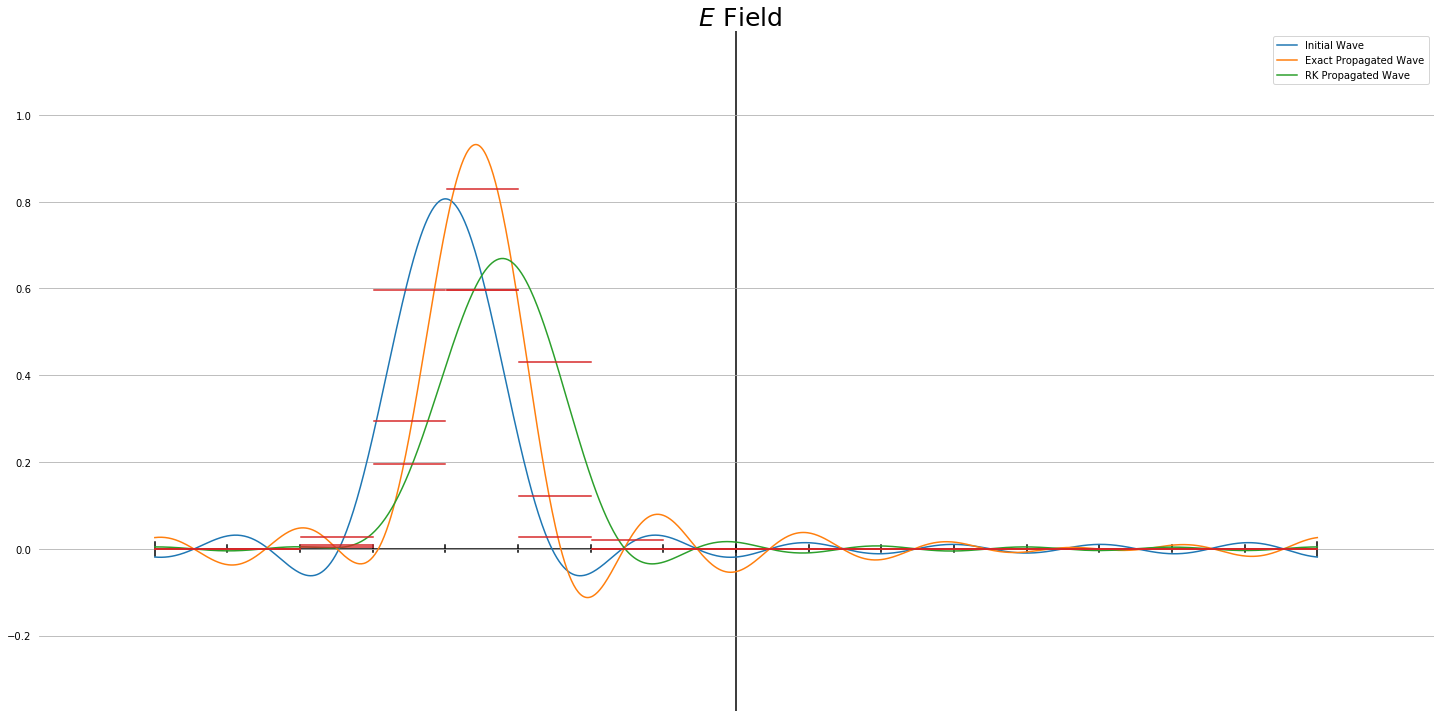

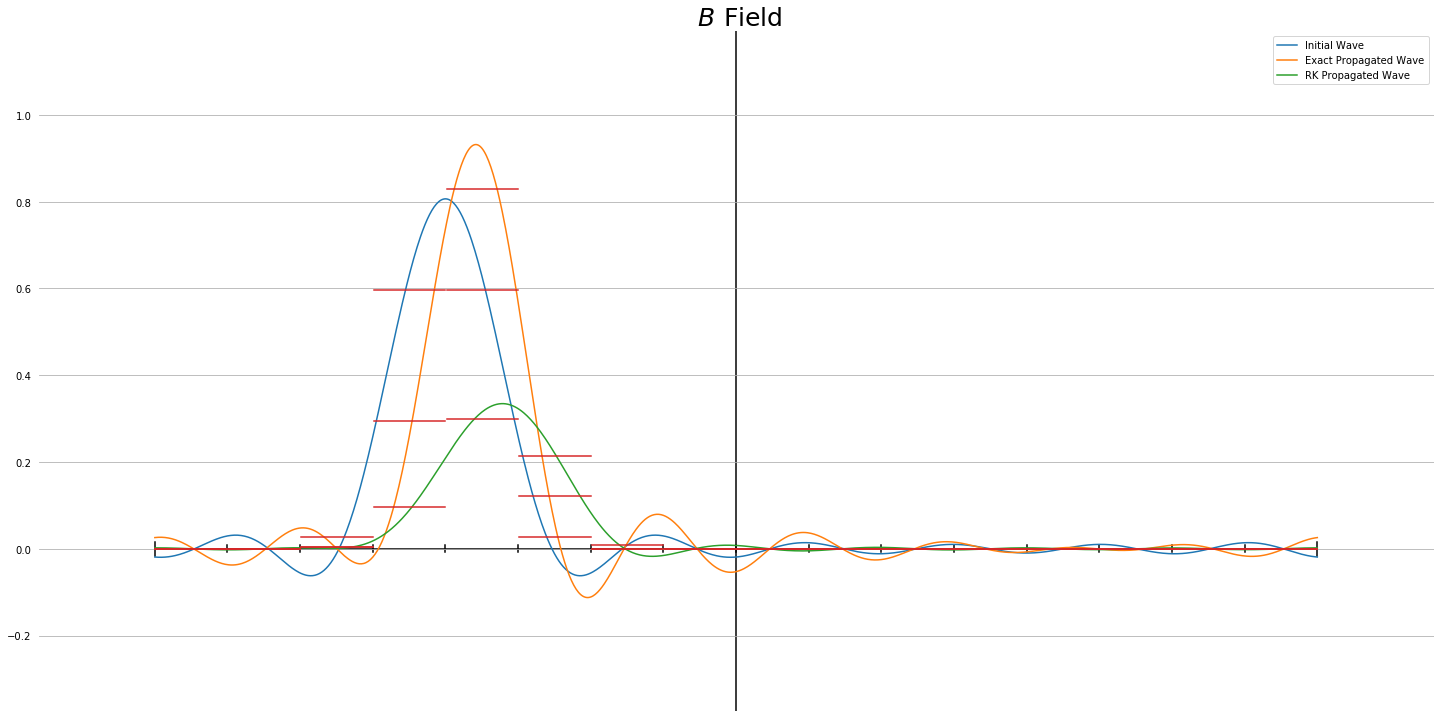

In [18]:
PT.PlotMixedWave(omegaC, physicsC, waves = wavesC, FCoefs = allCoefsC, rescale = 5, yGrid = True, labels = labels, saveName = 'RKWaveEqAttempt')#, saveName = 'Coarse', dpi = 300)
# PT.PlotMixedWave(omegaF, physicsF, waves = wavesF, FCoefs = allCoefsF, rescale = 5, yGrid = True)#, labels = labels, title = 'Fine-Grid Mode Propagation', saveName = 'Fine', dpi = 300)
# PT.PlotMixedWave(omegaAMR, physicsAMR, waves = wavesAMR, FCoefs = allCoefsAMR, rescale = 5, yGrid = True)#, labels = labels, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)


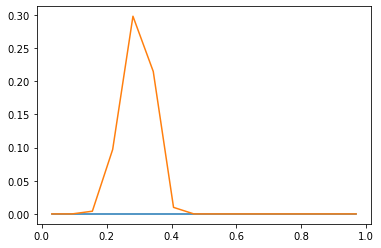

In [19]:
xC = omegaC.xCell
plt.figure()
plt.plot(xC, vC[:nh_min])
plt.plot(xC, vC[nh_min:])
plt.show()


In [20]:
# Notes for Sasha:
#
# Make residuals test of Gaussian (first unpropagated, then propagated) to assess its validity.


In [21]:
waveMat = OT.Block(wavesC, var = 2)
solvRes = waveMat @ solverCoefsC
print(solvRes[:nh_min])
print(solvRes[nh_min:])
print('')

[ 0.          0.00001088  0.00819161  0.19440661  0.59644177  0.42991335  0.01972375  0.00002627  0.          0.         -0.          0.          0.          0.          0.         -0.        ]
[ 0.          0.00000544  0.0040958   0.09720331  0.29822088  0.21495668  0.00986187  0.00001314  0.          0.         -0.          0.          0.          0.          0.          0.        ]



In [22]:
dx, dt = ST.FindDxDt(omegaC, CFL, cMatC)
print(dt)

0.02209708691207961


In [23]:
# Upwind

2.41421356, -0.41421356 # nh_min = 32, CFL = np.sqrt(0.5)
0.011048543456039806

2, 0 # nh_min = 32, CFL = 0.5
0.0078125

2, 0 # nh_min = 16, CFL = 0.5
0.015625

0.015625

In [24]:
print(1.41421356 / 0.011048543456039806)
print(1. / 0.0078125)
print(1. / 0.015625)

127.99999978521195
128.0
64.0


In [25]:
l = omegaC.levels
print(l)

0
